In this notebook, I use Python to download hourly data (though the granularity is easily adjustable) for the current year and for a number of currency pairs. After saving the downloaded data, I retain the 'Close' prices and compute correlation as a diversification measure toward portfolio building. Note that I use 'Bid' and 'Ask', just as a matter of demonstration. The workhorse here is the [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html); well worth spending a lot of time on.
The brokerage I access is [OANDA](https://www.oanda.com/),  which is pretty [friendly toward developers](http://developer.oanda.com/), and where I have a practice account.

<!-- TEASER_END -->

First, the obligatory module imports...

In [1]:
import pandas as pd
import numpy as np
import oandapy as oy
import os
import seaborn as sb
import matplotlib.pyplot as pl
from tqdm import tqdm_notebook
% matplotlib inline

Second, define OANDA access. Here you'll need to open an account and obtain access credentials in the form of ID and token. Both token and ID are set as variables, specified below, in my bash profile, where python can readily retrieve them.

In [2]:
tok = os.getenv('OANDA_API_ACCESS_TOKEN')
oid = os.getenv('OANDA_API_ACCESS_ID')
oanda = oy.API(environment='practice', access_token=tok)

Third, define the date range (here the whole of 2017, as of this writing) of the data and the instruments to be downloaded.

In [3]:
dateStart = '2017-01-01'
dateEnd = '2017-07-14'
instruments = ['USD_JPY', 'EUR_USD', 'GBP_USD', 'CAD_JPY',
               'USD_CHF', 'EUR_JPY', 'EUR_CAD', 'AUD_USD']

Fourth, define the data structures that will contain the pairs data, and specify the granularity the data will be served with; in this case "H" for hourly.

In [4]:
dfCloseBid = pd.DataFrame(columns=instruments)
dfCloseAsk = pd.DataFrame(columns=instruments)
dates = pd.date_range(start=dateStart, end=dateEnd, freq='H')

Next is to download and store (might as well) the data for each instrument, and retain the "Close" data for cross-correlation analysis.

In [7]:
for instr in tqdm_notebook(instruments):
    df = pd.DataFrame()
    for i in tqdm_notebook(range(dates.size-1), leave=False):
        d1 = str(dates[i]).replace(' ', 'T')
        d2 = str(dates[i+1]).replace(' ', 'T')
        try:
            data = oanda.get_history(instrument=instr, start=d1, end=d2, granularity='H1')
            df = df.append(pd.DataFrame(data['candles']))
        except:
            pass
    df.index = pd.DatetimeIndex(df.time)
    dfCloseBid[instr] = df['closeBid']
    dfCloseAsk[instr] = df['closeAsk']
    # Save Data to HDF5
    with pd.HDFStore('/Users/PoFA/DATAFILES/FX/OANDA/%s_170101_170101_1H' % instr + '.h5s', 'w', format='table') as h5s:
        h5s['data'] = df

Let's take a look at what the first few lines of the last currency dataframe looks like:

In [8]:
df.head()

,closeAsk,closeBid,complete,highAsk,highBid,lowAsk,lowBid,openAsk,openBid,time,volume
2017-01-02 23:00:00,0.71970,0.71950,True,0.72045,0.72026,0.71935,0.71916,0.71998,0.71963,2017-01-02T23:00:00.000000Z,453
2017-01-03 00:00:00,0.71955,0.71939,True,0.72048,0.72031,0.71954,0.71936,0.71966,0.71944,2017-01-03T00:00:00.000000Z,300
2017-01-03 01:00:00,0.72175,0.72158,True,0.72178,0.72163,0.71953,0.71939,0.71959,0.71942,2017-01-03T01:00:00.000000Z,559
2017-01-03 02:00:00,0.72257,0.72240,True,0.72266,0.72248,0.72166,0.72150,0.72170,0.72153,2017-01-03T02:00:00.000000Z,305
2017-01-03 03:00:00,0.72306,0.72294,True,0.72326,0.72310,0.72245,0.72229,0.72252,0.72237,2017-01-03T03:00:00.000000Z,243


And a quick look at one of the Close prices dataframes:

In [9]:
dfCloseAsk.head()

,USD_JPY,EUR_USD,GBP_USD,CAD_JPY,USD_CHF,EUR_JPY,EUR_CAD,AUD_USD
2017-01-02 23:00:00,117.468,1.04583,1.22836,87.407,1.02434,122.849,1.40579,0.71970
2017-01-03 00:00:00,117.367,1.04669,1.22900,87.337,1.02309,122.847,1.40682,0.71955
2017-01-03 01:00:00,117.396,1.04765,1.22999,87.438,1.02201,122.985,1.40677,0.72175
2017-01-03 02:00:00,117.394,1.04729,1.22985,87.510,1.02249,122.938,1.40504,0.72257
2017-01-03 03:00:00,117.388,1.04855,1.23049,87.546,1.02166,123.080,1.40612,0.72306


Computing correlations for each Close price dataframes couldn't be easier. Here Pearson correlation is the default. The result is another dataframe.

In [10]:
dfCorrBid = dfCloseBid.corr()
dfCorrAsk = dfCloseAsk.corr()

And here is what the first five lines of one of those dataframes looks like

In [11]:
dfCorrAsk.head()

,USD_JPY,EUR_USD,GBP_USD,CAD_JPY,USD_CHF,EUR_JPY,EUR_CAD,AUD_USD
USD_JPY,1.000000,-0.348350,-0.465465,0.792860,0.457551,0.292918,-0.433020,-0.203555
EUR_USD,-0.348350,1.000000,0.811608,-0.187940,-0.964338,0.794095,0.836692,-0.008566
GBP_USD,-0.465465,0.811608,1.000000,-0.430874,-0.757352,0.527744,0.823266,-0.150207
CAD_JPY,0.792860,-0.187940,-0.430874,1.000000,0.196967,0.324807,-0.591251,0.233998
USD_CHF,0.457551,-0.964338,-0.757352,0.196967,1.000000,-0.686442,-0.752530,-0.150557


This is great but it's much more intuitive to use a graphical representation. I will use [seaborn's heatmap](http://seaborn.pydata.org/generated/seaborn.heatmap.html). A pairwise correlation matrix contains duplicates on either side of the main diagonal. Since, in our heatmap, the lower triangle will touch both bottom abscissa and left ordinate, it will make for easier reading to get rid of the upper triangle and reduce the ink/data ratio. The next two lines create a mask that I'll apply to the plotting code in the subsequent cell.

In [12]:
mask = np.zeros_like(dfCorrBid)
mask[np.triu_indices_from(dfCorrBid.values)] = True

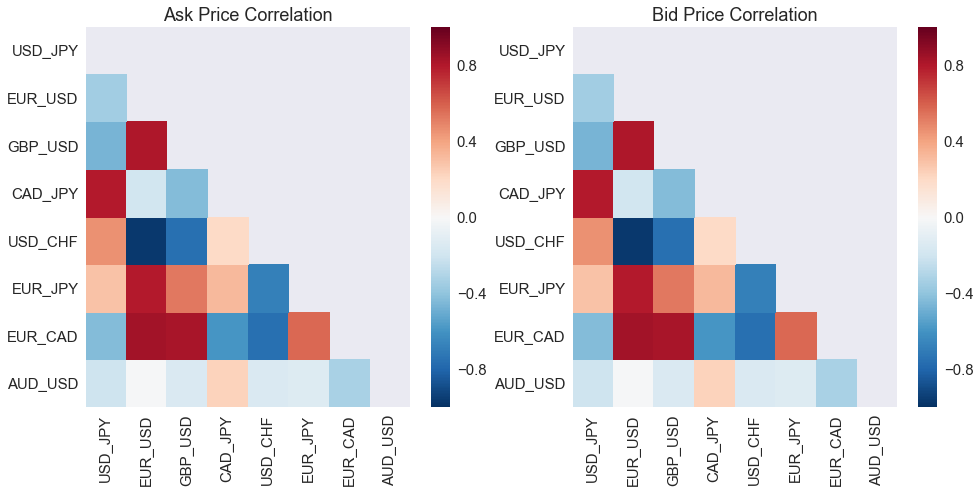

In [14]:
sb.set(font_scale=1.5)
f, ax = pl.subplots(ncols=2, figsize=(16, 7))
sb.heatmap(dfCorrAsk, mask=mask, ax=ax[0]);
ax[0].set_title('Ask Price Correlation')
sb.heatmap(dfCorrBid, mask=mask, ax=ax[1])
ax[1].set_title('Bid Price Correlation');

What if I want to select pairs that have a correlation coefficient with -0.5 and 0.5? Specify a second mask and replot, adding the new mask to the first mask:

In [16]:
mask2 = np.where(dfCorrAsk.abs()>0.5, True, False)

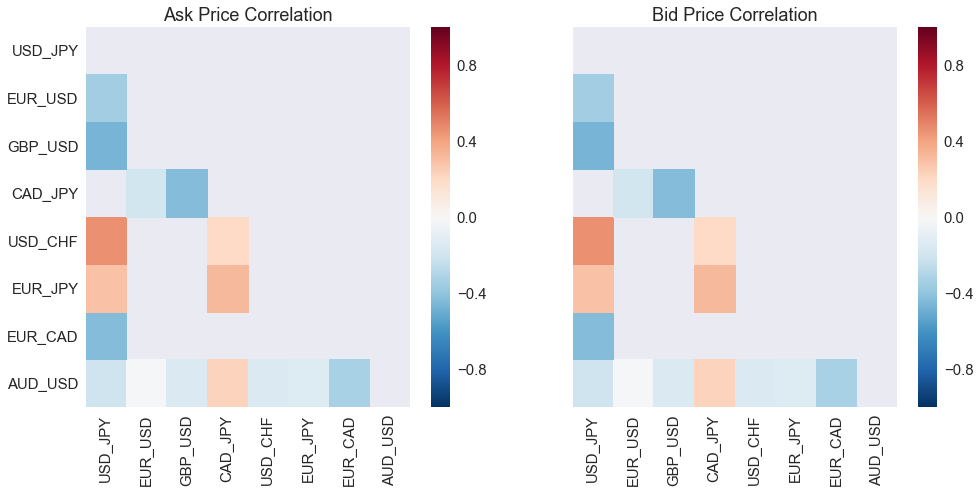

In [19]:
sb.set(font_scale=1.5)
f, ax = pl.subplots(ncols=2, figsize=(16, 7), sharey=True)
sb.heatmap(dfCorrAsk, mask=mask+mask2, ax=ax[0]);
ax[0].set_title('Ask Price Correlation')
sb.heatmap(dfCorrBid, mask=mask+mask2, ax=ax[1])
ax[1].set_title('Bid Price Correlation');

This suggests a number of combination of currency pairs to add to a trading portfolio; e.g. *AUDUSD*, *CADJPY*, *USDCHF*. It would not be prudent however to limit the analysis to this time frame alone. For kicks I'll repeat this exercise for the '4H', 'D', and 'W' timeframes, and plot the results side by side.

These steps should be done in a number of other time frames, depending on the type of trader doing the analysis and the particulars of the trading algorithm. 

Here I use the **resample** method, and use the last closing price of the 1H timeframe to recompute the new Close price:

In [25]:
dfCloseAskWeekly = dfCloseAsk.resample('1W').last()
dfCloseAskDaily = dfCloseAsk.resample('1D').last()
dfCloseAsk4H = dfCloseAsk.resample('4H').last()

Compute the corresponding correlations:

In [26]:
dfCorrAskWeekly = dfCloseAskWeekly.corr()
dfCorrAskDaily = dfCloseAskDaily.corr()
dfCorrAsk4H = dfCloseAsk4H.corr()

And plot, again applying the upper triangle mask to reduce the visual clutter:

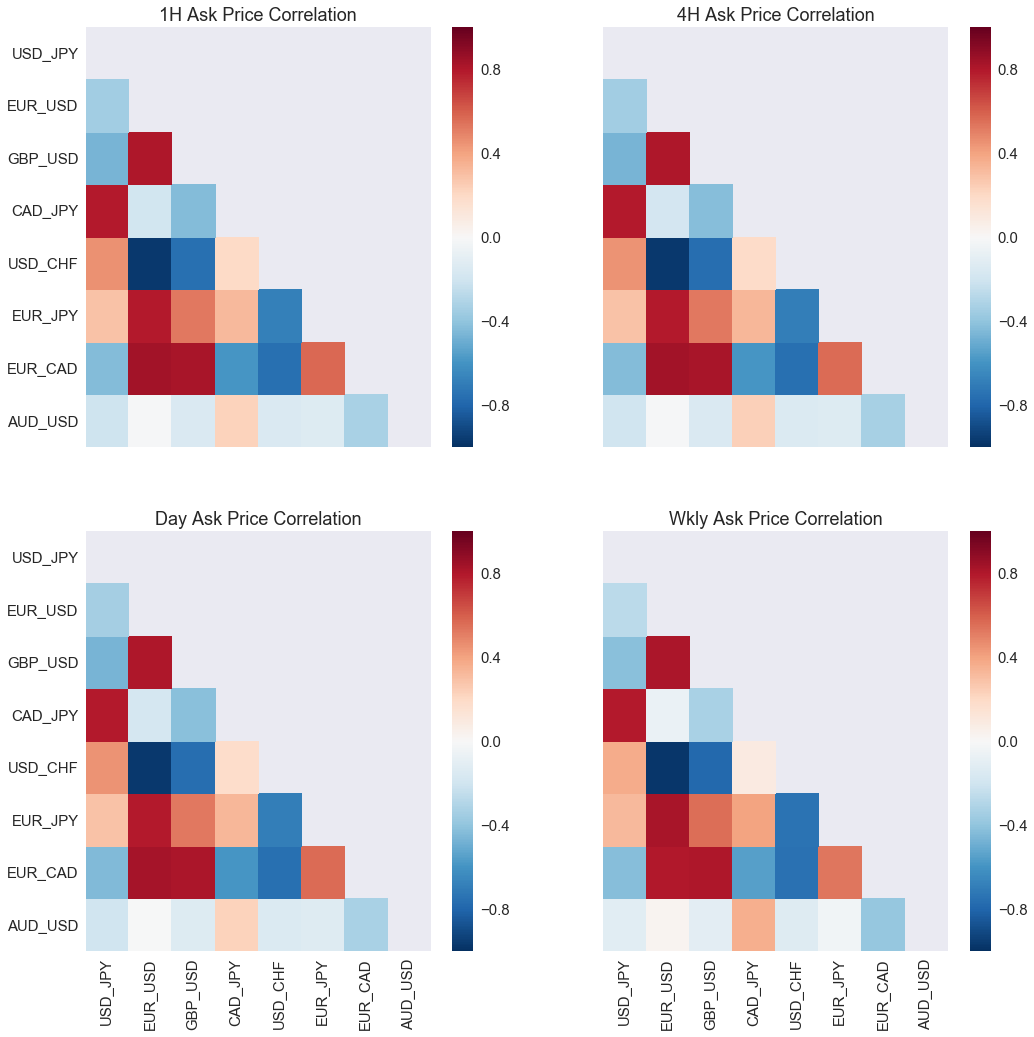

In [28]:
sb.set(font_scale=1.5)
f, ax = pl.subplots(ncols=2, nrows=2, figsize=(17, 17), sharey=True, sharex=True)
sb.heatmap(dfCorrAsk, mask=mask, ax=ax[0, 0])
ax[0, 0].set_title('1H Ask Price Correlation')
sb.heatmap(dfCorrAsk4H, mask=mask, ax=ax[0, 1]);
ax[0, 1].set_title('4H Ask Price Correlation')
sb.heatmap(dfCorrAskDaily, mask=mask, ax=ax[1, 0])
ax[1, 0].set_title('Day Ask Price Correlation');
sb.heatmap(dfCorrAskWeekly, mask=mask, ax=ax[1, 1])
ax[1, 1].set_title('Wkly Ask Price Correlation');

Changes are pretty subtle and would probably not alter e.g. the basket proposed earlier. That said re-doing the selection mask should be pretty easy at this point and left to the reader as an exercise.
That's it for this post. Have a plentiful harvest!